In [1]:
# DO NOT MODIFY
import nbimporter
import cv2

import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.morphology import distance_transform_edt

from q2 import briefLite,briefMatch,plotMatches
from q3 import computeH_ransac

## Question 4: Stitching Panoramas (15 points)

We can also use homographies to create a panorama image from multiple views of the same scene. This is possible for example when there is no camera translation between the views (e.g., only rotation about the camera center). First, you will generate panoramas using matched point correspondences between images using the BRIEF matching. **We will assume that there is no error in your matched point correspondences between images (Although there might be some errors, and even small errors can have drastic impacts)**.

### 4.1 Image Stitching (5 pts)

In this problem you will implement and use the function: 

\begin{equation}
    \texttt{[panoImg] = imageStitching(img1, img2, H2to1)}
\end{equation}

on two images from the Dusquesne incline. This function accepts two images and the output from the homography estimation function. This function:

   1. Warps $\texttt{img2}$ into $\texttt{img1}'s$ reference frame using the OpenCV $\texttt{warpPerspective}$ function;
   2. Blends $\texttt{img1}$ and warped $\texttt{img2}$ and outputs the panorama image. 

For this problem, use the provided images $\texttt{pnc1}$ as $\texttt{img1}$ and $\texttt{pnc0}$ as $\texttt{img2}$. The point correspondences $\texttt{pts}$ are generated by your BRIEF descriptor matching.

Apply your $\texttt{computeH_ransac()}$ to these correspondences to compute $\texttt{H2to1}$, which is the homography from $\texttt{pnc0}$ onto $\texttt{pnc1}$. Then apply this homography to $\texttt{pnc0}$ using $\texttt{cv2.warpPerspective()}$.

**This question will be manually graded. Visualize the warped image. Please include the image and your H2to1 matrix (with the bottom right index as 1) in your writeup PDF, along with stating which image pair you used.**

In [2]:
def imageStitching(im1, im2, H2to1, pad=((0, 0), (0, 500), (0, 0))):
    '''
    Returns a panorama of im1 and im2 using the given 
    homography matrix

    INPUT
        Warps img2 into img1 reference frame using the provided warpH() function
        H2to1 - a 3 x 3 matrix encoding the homography that best matches the linear
                 equation.
    OUTPUT
        img_pano - the panorama image.
    '''
    
    padded_im1 = np.pad(im1, pad)    
    warped_img = cv2.warpPerspective(im2, H2to1, padded_im1.shape[-2: -4: -1])
    
    # Generating weights for alpha blending.
    w1 = distance_transform_edt(np.pad(np.ones_like(im1[1: -1, 1: -1, 0]), 1))
    w2 = distance_transform_edt(np.pad(np.ones_like(im2[1: -1, 1: -1, 0]), 1))
    
    # Padding w1 as required to maintain right weight distribution.
    padded_w1 = np.pad(w1, pad[0: 2]) 
    padded_w1 = padded_w1.reshape(padded_w1.shape[0], -1, 1)
    
    # Warping weights for im2 to the target shape.
    warped_w2 = cv2.warpPerspective(w2, H2to1, padded_im1.shape[-2: -4: -1])
    warped_w2 = warped_w2.reshape(warped_w2.shape[0], -1, 1)
    
    img_pano = np.uint8((padded_im1 * padded_w1 + warped_img * warped_w2) / (padded_w1 + warped_w2))
    
    return img_pano

H: [[ 6.62560871e-01 -4.02131410e-02  3.63633562e+02]
 [-7.64843682e-02  8.76858624e-01 -1.74603452e+01]
 [-3.47656219e-04 -1.19278918e-05  1.00000000e+00]]


/tmp/ipykernel_4372/270683366.py:29: RuntimeWarning: invalid value encountered in true_divide
  img_pano = np.uint8((padded_im1 * padded_w1 + warped_img * warped_w2) / (padded_w1 + warped_w2))


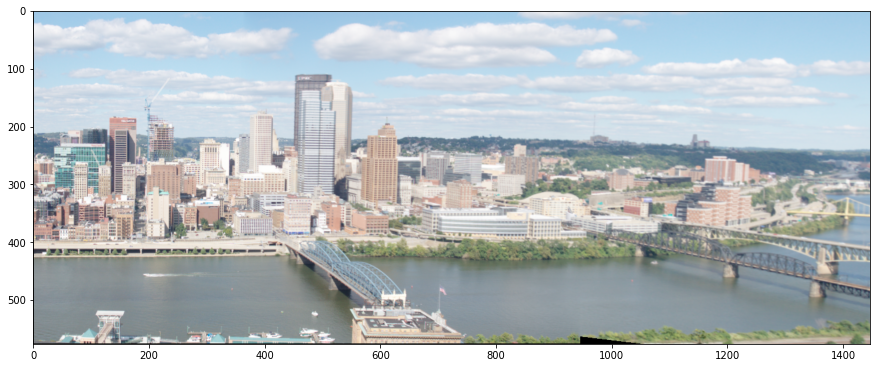

In [3]:
im1 = cv2.cvtColor(cv2.imread('data/incline_L.png'), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread('data/incline_R.png'), cv2.COLOR_BGR2RGB)

locs1, desc1 = briefLite(im1)
locs2, desc2 = briefLite(im2)
matches = briefMatch(desc1, desc2)

H, inliers = computeH_ransac(matches, locs1, locs2)

print('H: {0}'.format(H / H[2, 2]))

img_pano = imageStitching(im1, im2, H)

plt.rcParams['figure.figsize'] = (15, 15)
plt.imshow(img_pano)
plt.show()

### 4.2 Image Stitching with No Clip (3 pts)

Notice how the output from Q 4.1 is clipped at the edges? We will fix this now. Implement a function 

\begin{equation}
    \texttt{[panoImg] = imageStitching_noClip(img1, img2, H2to1)}
\end{equation}

that takes in the same input types and produces the same outputs as in Q 4.1.

To prevent clipping at the edges, we instead need to warp _both_ image 1 and image 2 into a common third reference frame in which we can display both images without any clipping. Specifically, we want to find a matrix $M$ that _only_ does scaling and translation such that:

\begin{equation}
    \texttt{warp_im1 = CV2.warpPerspective(im1, M, out_size);}
\end{equation}
\begin{equation}
    \texttt{warp_im2 = CV2.warpPerspective(im2, M*H2to1, out_size);}
\end{equation}

This produces warped images in a common reference frame where all points in $\texttt{im1}$ and $\texttt{im2}$ are visible. To do this, we will only take as input either the width or height of $\texttt{out_size}$ and compute the other one based on the given images such that the warped images are not squeezed or elongated in the panorama image. For now, assume we only take as input the width of the image (i.e., $\texttt{out_size(2)}$) and should therefore compute the correct height(i.e., $\texttt{out_size(1)}$).

_Hint:_ The computation will be done in terms of $\texttt{H2to1}$ and the extreme points (corners) of the two images.
Make sure $M$ includes only scale (find the aspect ratio of the full-sized panorama image) and translation. 

**This question will be manually graded. Visualize the warped image. Please include the image in your writeup PDF, along with stating which image pair you used.**

In [4]:
def imageStitching_noClip(im1,
                          im2,
                          H2to1,
                          pad=500,
                          isPadWidth=True,
                          M=np.array([[0.8, 0, 50],
                                      [0, 0.8, 200],
                                      [0, 0, 1.]])):
    '''
    Returns a panorama of im1 and im2 using the given 
    homography matrix without cliping.
    
    INPUTS
        im1 and im2 - images to be stitched.
        H2to1- the homography matrix.
        pad - Number of pixels to increase width by. Default 500
        M - scaling and translation matrix.
    OUTPUT
        img_pano - the panorama image.
    ''' 
    
    if isPadWidth:
        w, h = im1.shape[1] + pad, (im1.shape[0] * (im1.shape[1] + pad)) // im1.shape[1]
    else:
        w, h = (im1.shape[1] * (im1.shape[0] + pad)) // im1.shape[0], im1.shape[0] + pad
    
    out_size = (w, h)
    
    warp_im1 = cv2.warpPerspective(im1, M, out_size)
    warp_im2 = cv2.warpPerspective(im2, M @ H2to1, out_size)
    
#     plt.imshow(warp_im1)
#     plt.show()
    
#     plt.imshow(warp_im2)
#     plt.show()    
        
    # Generating weights for alpha blending.
    w1 = distance_transform_edt(np.pad(np.ones_like(im1[1: -1, 1: -1, 0]), 1))
    w2 = distance_transform_edt(np.pad(np.ones_like(im2[1: -1, 1: -1, 0]), 1))
    
    # Warping weights for im1 to the target shape.
    warp_w1 = cv2.warpPerspective(w1, M, out_size)
    warp_w1 = warp_w1.reshape(warp_w1.shape[0], -1, 1)
    
    # Warping weights for im2 to the target shape.
    warp_w2 = cv2.warpPerspective(w2, M @ H2to1, out_size)
    warp_w2 = warp_w2.reshape(warp_w2.shape[0], -1, 1)
    
    img_pano = np.uint8((warp_im1 * warp_w1 + warp_im2 * warp_w2) / (warp_w1 + warp_w2))
    
    return img_pano

H: [[ 6.61482751e-01 -2.66085406e-02  3.62090404e+02]
 [-7.96009537e-02  8.89908480e-01 -1.96428475e+01]
 [-3.55070191e-04  6.48142776e-06  1.00000000e+00]]


/tmp/ipykernel_4372/2385474131.py:50: RuntimeWarning: invalid value encountered in true_divide
  img_pano = np.uint8((warp_im1 * warp_w1 + warp_im2 * warp_w2) / (warp_w1 + warp_w2))


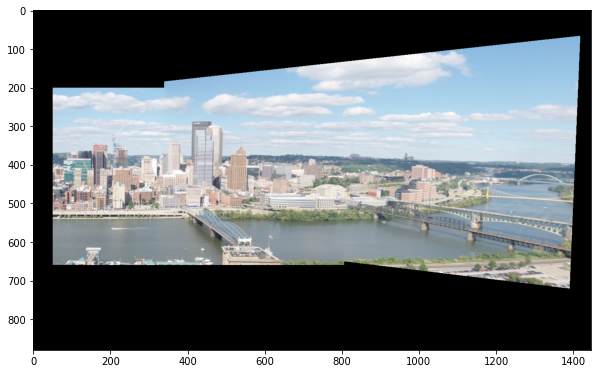

In [5]:
im1 = cv2.cvtColor(cv2.imread('data/incline_L.png'), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread('data/incline_R.png'), cv2.COLOR_BGR2RGB)

locs1, desc1 = briefLite(im1)
locs2, desc2 = briefLite(im2)
matches = briefMatch(desc1, desc2)

H, inliers = computeH_ransac(matches, locs1, locs2)
print('H: {0}'.format(H / H[2, 2]))

img_pano = imageStitching_noClip(im1, im2, H)

plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(img_pano)
plt.show()

### 4.3 Generate Panorama (2 pts)

You now have all the tools you need to automatically generate panoramas. Write a function that accepts two images as input, computes keypoints and descriptors for both the images, finds putative feature correspondences by matching keypoint descriptors, estimates a homography using RANSAC and then warps one of the images with the homography so that they are aligned and then overlays them. 

\begin{equation}
\texttt{im3 = generatePanorama(im1, im2)}
\end{equation}

Run your code on the image pair $\texttt{data/pnc1.jpg}$, $\texttt{data/pnc0.jpg}$ or $\texttt{data/incline_L.jpg}$, $\texttt{data/incline_R.jpg}$. However during debugging, try on scaled down versions of the images to keep running time low. 

**This question will be manually graded. Save the resulting panorama on the full sized images and include the figure and computed homography matrix in your writeup.**

In [7]:
def generatePanorama(im1, im2):
    '''
    Gnerate a panorama from two images.
    
    INPUTS
        im1 and im2 - images to be stitched.
    OUTPUT
        img_pano - the panorama image.
    '''
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

    locs1, desc1 = briefLite(im1)
    locs2, desc2 = briefLite(im2)
    matches = briefMatch(desc1, desc2)
    H, inliers = computeH_ransac(matches, locs1, locs2)
    print('H: {0}'.format(H / H[2, 2]))


    img_pano = imageStitching_noClip(im1, im2, H)
    
    return img_pano

H: [[ 6.70688040e-01 -3.24766846e-02  3.61588728e+02]
 [-7.62290199e-02  8.90118506e-01 -2.09211372e+01]
 [-3.42501786e-04 -2.92305590e-06  1.00000000e+00]]


/tmp/ipykernel_4372/2385474131.py:50: RuntimeWarning: invalid value encountered in true_divide
  img_pano = np.uint8((warp_im1 * warp_w1 + warp_im2 * warp_w2) / (warp_w1 + warp_w2))


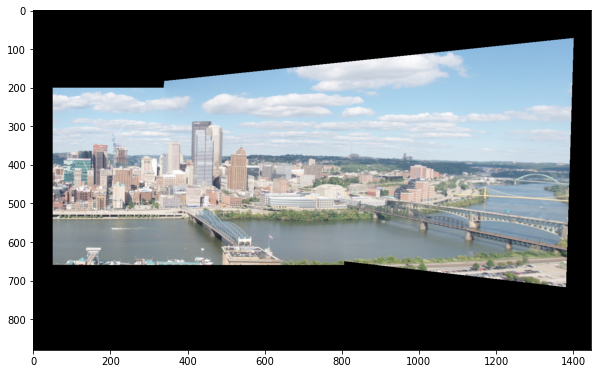

In [8]:
im1 = cv2.imread('data/incline_L.png')
im2 = cv2.imread('data/incline_R.png')

img_pano = generatePanorama(im1, im2)

plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(img_pano)
plt.show()

### 4.4 extra credits (3 pts)

Collect a pair of your own images (with your phone) and stitch them together using your code from the previous section. Include the pair of images and their result in the write-up.

/home/punit13/personal/fall21/16720/assignments/hw4/keypointDetect.py:87: RuntimeWarning: divide by zero encountered in true_divide
  principal_curvature = np.divide(np.square(np.add(gxx, gyy)), (np.multiply(gxx, gyy) - np.multiply(gxy, gyx)))
/home/punit13/personal/fall21/16720/assignments/hw4/keypointDetect.py:87: RuntimeWarning: invalid value encountered in true_divide
  principal_curvature = np.divide(np.square(np.add(gxx, gyy)), (np.multiply(gxx, gyy) - np.multiply(gxy, gyx)))


H: [[ 5.85071839e-01 -2.54551811e-02  7.22584132e+02]
 [-2.88148403e-01  9.70842580e-01  7.60692911e+00]
 [-3.89214812e-04  4.04245511e-05  1.00000000e+00]]


/tmp/ipykernel_4372/2385474131.py:50: RuntimeWarning: invalid value encountered in true_divide
  img_pano = np.uint8((warp_im1 * warp_w1 + warp_im2 * warp_w2) / (warp_w1 + warp_w2))


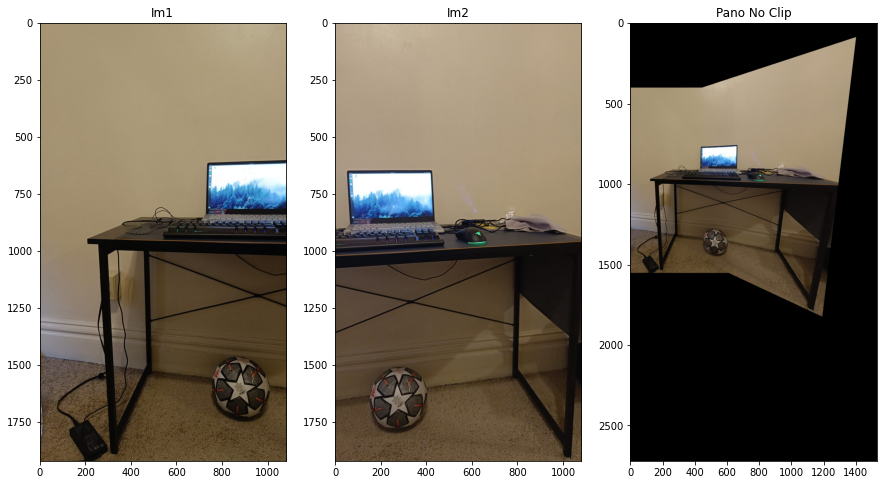

In [9]:
im1 = cv2.imread('data/custom_l.jpeg')
im2 = cv2.imread('data/custom_r.jpeg')

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

locs1, desc1 = briefLite(im1)
locs2, desc2 = briefLite(im2)
matches = briefMatch(desc1, desc2)

# plotMatches(im1, im2, matches, locs1, locs2)

H, inliers = computeH_ransac(matches, locs1, locs2)
print('H: {0}'.format(H / H[2, 2]))

M = np.array([[0.6, 0, 0],
              [0, 0.6, 400],
              [0, 0, 1.]])

img_pano = imageStitching_noClip(im1, im2, H, pad=800, isPadWidth=False, M=M)

fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(im1)
axes[0].set_title('Im1')
axes[1].imshow(im2)
axes[1].set_title('Im2')
axes[2].imshow(img_pano)
axes[2].set_title('Pano No Clip')
plt.show()

### 4.5 extra credits (2 pts)

Collect at least 6 images  and stitch them into a single noClip image. You can either collect your own, or use the [PNC Park images](http://www.cs.jhu.edu/~misha/Code/SMG/PNC3.zip) from Matt Uyttendaele. We used the PNC park images (subsmapled to 1/4 sized) and ORB keypoints and descriptors for our reference solution.